In [1]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import recall_score, roc_curve, auc
import numpy as np

In [2]:
class AutismDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []

        for category in os.listdir(root_dir):
            category_dir = os.path.join(root_dir, category)
            if os.path.isdir(category_dir):
                for participant_folder in os.listdir(category_dir):
                    participant_path = os.path.join(category_dir, participant_folder)
                    if os.path.isdir(participant_path):
                        image_paths = []
                        for img_name in os.listdir(participant_path):
                            if img_name.lower().endswith((".jpg", ".jpeg", ".png")):
                                img_full_path = os.path.join(participant_path, img_name)
                                if os.path.isfile(img_full_path):
                                    image_paths.append(img_full_path)
                        if image_paths:
                            self.data.append(image_paths)
                            label = 0 if category == 'TC' else 1
                            self.labels.append(label)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        images = self.data[idx]
        label = self.labels[idx]
        processed_images = [self.transform(Image.open(img).convert("RGB")) for img in images]
        return torch.stack(processed_images), label

In [3]:
def collate_fn(batch):
    images, labels = zip(*batch)
    lengths = [img_seq.size(0) for img_seq in images]
    c, h, w = images[0].size(-3), images[0].size(-2), images[0].size(-1)
    max_seq_len = max(lengths)
    padded_images = torch.zeros(len(images), max_seq_len, c, h, w)

    for i, img_seq in enumerate(images):
        padded_images[i, :len(img_seq)] = img_seq

    return padded_images, lengths, torch.tensor(labels)

In [4]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self, x):
        with torch.no_grad():
            features = self.resnet(x)
        features = features.view(features.size(0), -1)
        return features

class TransformerSequenceModel(nn.Module):
    def __init__(self, feature_dim, hidden_dim, num_layers, num_heads, dropout=0.5):
        super(TransformerSequenceModel, self).__init__()
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim
        self.input_proj = nn.Linear(feature_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, 
            nhead=num_heads, 
            dim_feedforward=hidden_dim * 4, 
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x, lengths):
        x = self.input_proj(x)
        max_len = x.size(1)
        mask = torch.arange(max_len, device=x.device).expand(len(lengths), max_len) >= torch.tensor(lengths, device=x.device).unsqueeze(1)
        transformer_output = self.transformer(x, src_key_padding_mask=mask)
        pooled_output = torch.mean(transformer_output, dim=1)
        output = self.fc(pooled_output)
        return output.view(-1)

    
class AutismPredictionModel(nn.Module):
    def __init__(self, cnn, feature_dim, hidden_dim, num_layers, num_heads, dropout=0.5):
        super(AutismPredictionModel, self).__init__()
        self.cnn = cnn
        self.sequence_model = TransformerSequenceModel(
            feature_dim=feature_dim,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            num_heads=num_heads,
            dropout=dropout
        )

    def forward(self, image_sequences, lengths):
        batch_size, seq_len, c, h, w = image_sequences.size()
        image_sequences = image_sequences.view(batch_size * seq_len, c, h, w)
        features = self.cnn(image_sequences)
        feature_dim = features.size(1)
        features = features.view(batch_size, seq_len, feature_dim)
        output = self.sequence_model(features, lengths)
        return output

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_dir = "./Dataset_Split4/Test"

test_dataset = AutismDataset(test_dir, transform)

test_loader = DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

/tmp/ipykernel_749445/1731635109.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_model_trans.pth"))


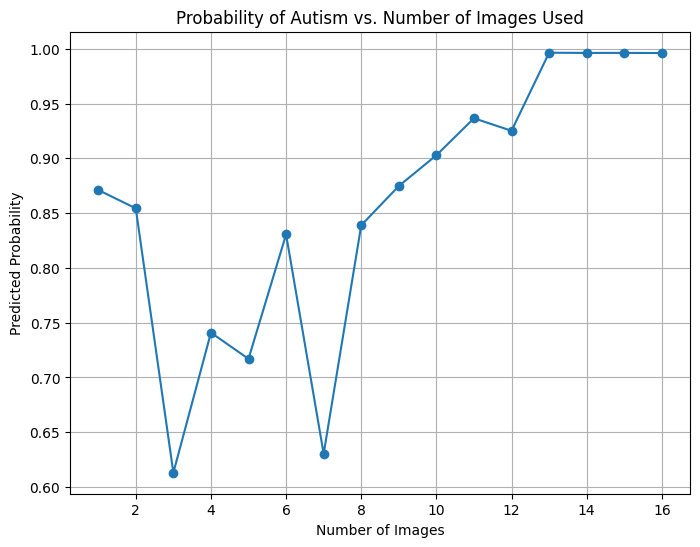

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = CNNFeatureExtractor().to(device)
best_model = AutismPredictionModel(cnn, feature_dim=2048, hidden_dim=128, num_heads=32,num_layers=2).to(device)
best_model.load_state_dict(torch.load("best_model_trans.pth"))
best_model.eval()

image_paths = [
    "./Dataset_Split4/Test/TS/19/TS009_19.png",
    "./Dataset_Split4/Test/TS/19/TS010_19.png",
    "./Dataset_Split4/Test/TS/19/TS023_19.png",
    "./Dataset_Split4/Test/TS/19/TS024_19.png",
    "./Dataset_Split4/Test/TS/19/TS025_19.png",
    "./Dataset_Split4/Test/TS/19/TS042_19.png",
    "./Dataset_Split4/Test/TS/19/TS043_19.png",
    "./Dataset_Split4/Test/TS/19/TS044_19.png",
    "./Dataset_Split4/Test/TS/19/TS064_19.png",
    "./Dataset_Split4/Test/TS/19/TS065_19.png",
    "./Dataset_Split4/Test/TS/19/TS066_19.png",
    "./Dataset_Split4/Test/TS/19/TS085_19.png",
    "./Dataset_Split4/Test/TS/19/TS086_19.png",
    "./Dataset_Split4/Test/TS/19/TS110_19.png",
    "./Dataset_Split4/Test/TS/19/TS111_19.png",
    "./Dataset_Split4/Test/TS/19/TS112_19.png",
]

probabilities = []

for i in range(1, len(image_paths) + 1):
    selected_images = image_paths[:i]
    image_tensors = []
    
    for img_path in selected_images:
        if os.path.isfile(img_path):
            img = Image.open(img_path).convert("RGB")
            img_tensor = transform(img)
            image_tensors.append(img_tensor)
        else:
            print(f"Image not found: {img_path}")
    
    if not image_tensors:
        raise ValueError("No valid images found for prediction.")
    
    image_sequence = torch.stack(image_tensors).unsqueeze(0)
    lengths = [len(image_tensors)]
    image_sequence = image_sequence.to(device)
    
    best_model.eval()
    with torch.no_grad():
        outputs = best_model(image_sequence, lengths)
        prob = torch.sigmoid(outputs).item()
        probabilities.append(prob)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(probabilities) + 1), probabilities, marker='o')
plt.title("Probability of Autism vs. Number of Images Used")
plt.xlabel("Number of Images")
plt.ylabel("Predicted Probability")
plt.grid()
plt.show()